In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
from datasets import load_dataset
tickets = load_dataset("Tobi-Bueck/customer-support-tickets")
# Convert to pandas for easier EDA
df = tickets['train'].to_pandas()
print(f"Dataset shape: {df.shape}")
print(df.columns.tolist())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

aa_dataset-tickets-multi-lang-5-2-50-ver(…):   0%|          | 0.00/26.0M [00:00<?, ?B/s]

(…)set-tickets-german_normalized_50_5_2.csv: 0.00B [00:00, ?B/s]

dataset-tickets-multi-lang-4-20k.csv:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/61765 [00:00<?, ? examples/s]

Dataset shape: (61765, 16)
['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']


In [ ]:
df.head()

,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,high,de,51.0,Security,Outage,Disruption,Data Breach,None,None,None,None
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51.0,Account,Disruption,Outage,IT,Tech Support,None,None,None
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51.0,Product,Feature,Tech Support,None,None,None,None,None
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51.0,Billing,Payment,Account,Documentation,Feedback,None,None,None
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51.0,Product,Feature,Feedback,Tech Support,None,None,None,None


In [ ]:
lengths = df['body'].str.len()
print("Length stats:", lengths.describe())


Length stats: count    61763.000000
mean       419.192996
std        223.850690
min          4.000000
25%        234.000000
50%        415.000000
75%        587.000000
max       2259.000000
Name: body, dtype: float64


In [ ]:
df.isna().sum()

,0
subject,5299
body,2
answer,13189
type,13178
queue,0
priority,0
language,0
version,33178
tag_1,13178
tag_2,13237


In [ ]:
df.shape

(61765, 16)

In [ ]:
df = df.dropna(subset=['body'])
df = df.reset_index(drop=True)


In [ ]:
df.shape

(61763, 16)

In [ ]:
top_queues = df['queue'].value_counts().nlargest(9).index.tolist()
df['queue_grouped'] = df['queue'].apply(lambda q: q if q in top_queues else 'Other')
print("Queues after grouping:", df['queue_grouped'].unique())


Queues after grouping: ['Technical Support' 'Returns and Exchanges' 'Billing and Payments'
 'Sales and Pre-Sales' 'Service Outages and Maintenance' 'Product Support'
 'IT Support' 'Customer Service' 'Human Resources' 'Other']


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9äöüß ]', ' ', text)  # keep alphanumeric (including German chars)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_body'] = df['body'].apply(clean_text)


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_WORDS = 10000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_body'])
sequences = tokenizer.texts_to_sequences(df['clean_body'])
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen, padding='post')


In [ ]:
import pickle
save_path="/content/drive/MyDrive/tokenizer.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(" Tokenizer saved successfully!")



 Tokenizer saved successfully!


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['queue_grouped'])
print("Classes:", le.classes_)


Classes: ['Billing and Payments' 'Customer Service' 'Human Resources' 'IT Support'
 'Other' 'Product Support' 'Returns and Exchanges' 'Sales and Pre-Sales'
 'Service Outages and Maintenance' 'Technical Support']


In [ ]:
save_path="/content/drive/MyDrive/label_encoder.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(le, f)

print(" Labelencoder saved successfully!")

 Labelencoder saved successfully!


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = min(MAX_WORDS, len(tokenizer.word_index)) + 1
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    LSTM(64),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_split=0.1, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_path = '/content/drive/MyDrive/best_model.h5'


early_stop = EarlyStopping(
    monitor='val_loss',      # metric to watch
    patience=4,              # stop after 4 epochs with no improvement
    restore_best_weights=True  # restore best model after stopping
)



checkpoint = ModelCheckpoint(
    filepath=model_path,     # save location
    monitor='val_loss',      # metric to monitor
    save_best_only=True,     # save only the best model
    verbose=1
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3435 - loss: 1.8775
Epoch 1: val_loss improved from inf to 1.56372, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 105s 74ms/step - accuracy: 0.3436 - loss: 1.8773 - val_accuracy: 0.4276 - val_loss: 1.5637
Epoch 2/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4459 - loss: 1.5486
Epoch 2: val_loss improved from 1.56372 to 1.55437, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 131s 66ms/step - accuracy: 0.4459 - loss: 1.5487 - val_accuracy: 0.4295 - val_loss: 1.5544
Epoch 3/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4459 - loss: 1.5513
Epoch 3: val_loss improved from 1.55437 to 1.54552, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 140s 65ms/step - accuracy: 0.4459 - loss: 1.5513 - val_accuracy: 0.4303 - val_loss: 1.5455
Epoch 4/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4511 - loss: 1.5340
Epoch 4: val_loss did not improve from 1.54552
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 145s 67ms/step - accuracy: 0.4511 - loss: 1.5340 - val_accuracy: 0.4250 - val_loss: 1.5602
Epoch 5/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4483 - loss: 1.5461
Epoch 5: val_loss improved from 1.54552 to 1.48004, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step - accuracy: 0.4483 - loss: 1.5461 - val_accuracy: 0.4653 - val_loss: 1.4800
Epoch 6/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4846 - loss: 1.4448
Epoch 6: val_loss improved from 1.48004 to 1.36797, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 142s 66ms/step - accuracy: 0.4846 - loss: 1.4448 - val_accuracy: 0.4975 - val_loss: 1.3680
Epoch 7/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5280 - loss: 1.3256
Epoch 7: val_loss improved from 1.36797 to 1.33904, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 95s 68ms/step - accuracy: 0.5280 - loss: 1.3255 - val_accuracy: 0.5131 - val_loss: 1.3390
Epoch 8/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5598 - loss: 1.2394
Epoch 8: val_loss improved from 1.33904 to 1.29611, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step - accuracy: 0.5598 - loss: 1.2394 - val_accuracy: 0.5301 - val_loss: 1.2961
Epoch 9/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5914 - loss: 1.1539
Epoch 9: val_loss improved from 1.29611 to 1.28450, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 94s 68ms/step - accuracy: 0.5914 - loss: 1.1539 - val_accuracy: 0.5485 - val_loss: 1.2845
Epoch 10/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6266 - loss: 1.0693
Epoch 10: val_loss improved from 1.28450 to 1.25127, saving model to /content/drive/MyDrive/best_model.h5


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 93s 67ms/step - accuracy: 0.6266 - loss: 1.0693 - val_accuracy: 0.5616 - val_loss: 1.2513
Epoch 11/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6537 - loss: 0.9902
Epoch 11: val_loss did not improve from 1.25127
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 95s 68ms/step - accuracy: 0.6537 - loss: 0.9902 - val_accuracy: 0.5756 - val_loss: 1.2579
Epoch 12/50
1389/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6846 - loss: 0.8952
Epoch 12: val_loss did not improve from 1.25127
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 139s 66ms/step - accuracy: 0.6846 - loss: 0.8952 - val_accuracy: 0.5778 - val_loss: 1.2870
Epoch 13/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7049 - loss: 0.8296
Epoch 13: val_loss did not improve from 1.25127
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 95s 68ms/step - accuracy: 0.7049 - loss: 0.8296 - val_accuracy: 0.5918 - val_loss: 1.2846
Epoch 14/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7417 - loss: 0.7503
Epoch 14: v

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))


387/387 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step
                                 precision    recall  f1-score   support

           Billing and Payments       0.80      0.74      0.77       975
               Customer Service       0.31      0.49      0.38      1484
                Human Resources       0.00      0.00      0.00       183
                     IT Support       0.38      0.00      0.01      1145
                          Other       0.99      0.95      0.97      2769
                Product Support       0.39      0.33      0.36      1792
          Returns and Exchanges       0.46      0.01      0.02       488
            Sales and Pre-Sales       0.53      0.06      0.10       298
Service Outages and Maintenance       0.81      0.35      0.48       382
              Technical Support       0.46      0.77      0.58      2837

                       accuracy                           0.57     12353
                      macro avg       0.51      0.37      0.37     12353
      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


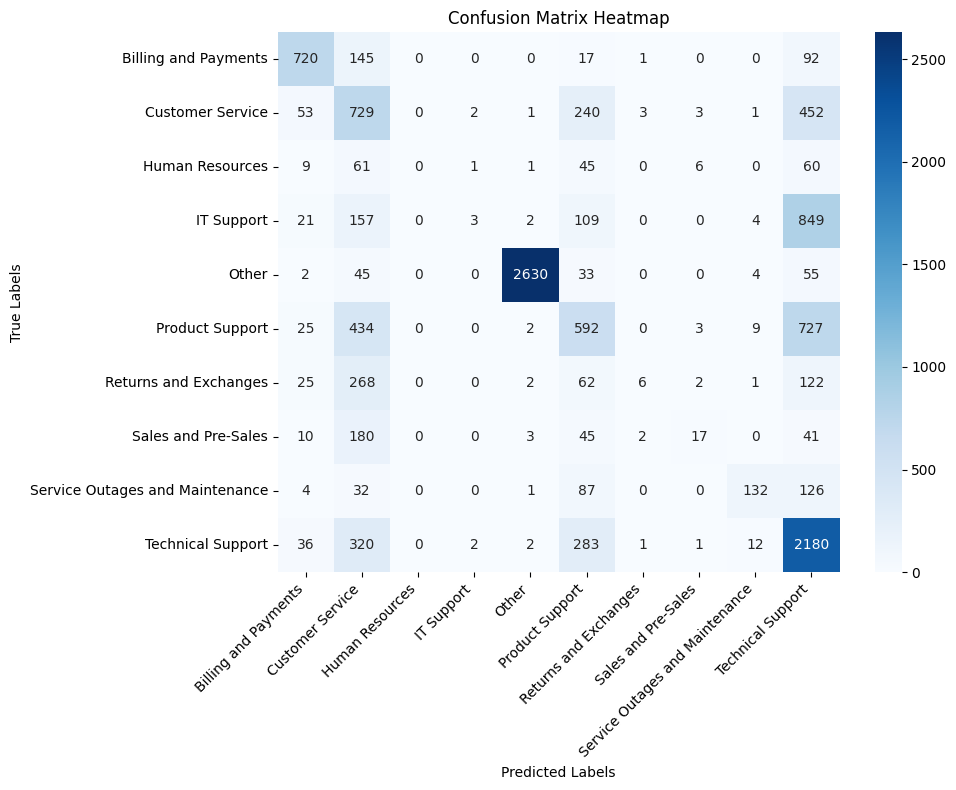

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [13]:
import pickle
import tensorflow as tf
import google.generativeai as genai
from google.colab import userdata
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9äöüß ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

maxlen = 100


tokenizer_path = "/content/drive/MyDrive/tokenizer.pkl"
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

label_encoder_path = "/content/drive/MyDrive/label_encoder.pkl"
with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)

model_path = '/content/drive/MyDrive/best_model.h5'
model = tf.keras.models.load_model(model_path)

google_api_key = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=google_api_key)
print(" Gemini API key configured via Colab Secrets.")

 Gemini API key configured via Colab Secrets.


In [14]:

print(" Available Gemini models:")
for m in genai.list_models():
    if 'generateContent' in m.supported_generation_methods:
        print(" -", m.name)

def gemini_generate_reply(ticket_text, predicted_queue):
    prompt = (
        f"You are a support assistant for {predicted_queue}.\n"
        f"Write a professional reply to this customer message:\n\n{ticket_text}\n\n"
        f"Your tone should be helpful and empathetic."
        f"Replying person name Omprakash from XYZ LLC"
    )
    model = genai.GenerativeModel("gemini-pro-latest")
    response = model.generate_content(prompt)
    return response.text

 Available Gemini models:
 - models/gemini-2.5-pro-preview-03-25
 - models/gemini-2.5-flash-preview-05-20
 - models/gemini-2.5-flash
 - models/gemini-2.5-flash-lite-preview-06-17
 - models/gemini-2.5-pro-preview-05-06
 - models/gemini-2.5-pro-preview-06-05
 - models/gemini-2.5-pro
 - models/gemini-2.0-flash-exp
 - models/gemini-2.0-flash
 - models/gemini-2.0-flash-001
 - models/gemini-2.0-flash-exp-image-generation
 - models/gemini-2.0-flash-lite-001
 - models/gemini-2.0-flash-lite
 - models/gemini-2.0-flash-preview-image-generation
 - models/gemini-2.0-flash-lite-preview-02-05
 - models/gemini-2.0-flash-lite-preview
 - models/gemini-2.0-pro-exp
 - models/gemini-2.0-pro-exp-02-05
 - models/gemini-exp-1206
 - models/gemini-2.0-flash-thinking-exp-01-21
 - models/gemini-2.0-flash-thinking-exp
 - models/gemini-2.0-flash-thinking-exp-1219
 - models/gemini-2.5-flash-preview-tts
 - models/gemini-2.5-pro-preview-tts
 - models/learnlm-2.0-flash-experimental
 - models/gemma-3-1b-it
 - models/gem

In [15]:
def predict_and_reply(text):
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post')
    pred_idx = model.predict(padded).argmax(axis=1)[0]
    pred_queue = label_encoder.inverse_transform([pred_idx])[0]
    print(f" Predicted Category: {pred_queue}")
    reply = gemini_generate_reply(text, pred_queue)
    return pred_queue, reply

In [16]:
example_ticket = "My internet connection is very slow today. I cannot browse websites or watch videos."
predicted_category, generated_reply = predict_and_reply(example_ticket)

print("\n Generated Reply:")
print(generated_reply)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
 Predicted Category: Technical Support

 Generated Reply:
Of course. Here is a professional reply you can use.

***

**Subject: Regarding Your Slow Internet Connection**

Hello,

Thank you for reaching out to XYZ LLC Support. My name is Omprakash, and I'm very sorry to hear that you're experiencing a slow internet connection today. I understand how frustrating it is when you can't browse websites or watch videos, and I'm here to help get this resolved for you.

Often, a simple restart of your equipment can fix this type of issue. Could you please try a "power cycle" by following these steps?

1.  Unplug both your modem and your router from the power outlet.
2.  Wait for 60 seconds. This allows the devices to fully reset.
3.  Plug the modem back in first. Wait for its lights to become solid and stable (usually about 2-3 minutes).
4.  Once the modem is online, plug your router back in and wait for it to boot up completely.

After a few minutes, plea

In [21]:
def generate_reply(body):
  predicted_category, generated_reply = predict_and_reply(body)

  print("\n Generated Reply:")
  print(generated_reply)

In [23]:
generate_reply(df['body'][1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
 Predicted Category: Product Support

 Generated Reply:
Of course. Here is a professional, helpful, and empathetic reply.

***

**Subject: Regarding the Account Management Portal Outage**

Dear [Customer Name],

Thank you for reaching out to us and for your detailed report about the centralized account management portal.

I sincerely apologize for the significant inconvenience this outage is causing. I understand how frustrating it is to be unable to access your account settings, and I appreciate you taking the time to perform troubleshooting steps on your end.

I can confirm that we are currently experiencing an unexpected outage with our account management portal. Our engineering team has been alerted and is investigating the issue with the highest priority. Please be assured that we are working to restore service as quickly as possible.

While we do not have a firm estimated time for resolution just yet, we are committed to providing updates as 

In [ ]:
generate_reply(df['body'][1])